# Efficacy

In [162]:
import os
import re
from datetime import datetime, timedelta
import seaborn as sns  # Seaborn for enhanced boxplot aesthetics

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from matplotlib.ticker import FuncFormatter, AutoLocator, AutoMinorLocator

ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'
dir_names = ['DA', 'DAR', 'NO']

## Filter logs

In [163]:
def get_log_files(directory):
    """
    Retrieves all log files in the specified directory.

    :param directory: Path to the directory to search for log files.
    :return: List of paths to log files found in the directory.
    """
    all_logs = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.log')]
    return all_logs


# Function to parse the log file and extract only WARNING log entries
def extract_warning_logs(input_path, output_path):
    with open(input_path, 'r') as input_file, open(output_path, 'w') as output_file:
        for line in input_file:
            if "WARNING" in line:
                output_file.write(line)


for log_dir in dir_names:
    log_files = get_log_files(log_dir)
    for log_file in log_files:
        if log_file.endswith('eval.log'):
            extract_warning_logs(log_file, log_file.replace('eval.log', 'eval_warn.log'))


## Load into df

In [164]:

# Function to parse a single log file
def parse_log_file(filepath):
    # Extract filename for column naming
    filename = re.search(ip_pattern, os.path.basename(filepath)).group(0)
    # Dictionary to store data
    data = {}
    with open(filepath, 'r', encoding='UTF-8') as file:
        for line in file:
            # Regular expression to find the timestamp and the float value
            match = re.search(r'.*>(.+?)<', line)
            if match:
                # timestamp = match.group(1)
                timestamp = line[:19]
                value = match.group(1)
                # Use the timestamp up to seconds for aggregation
                if timestamp in data:
                    # Append if there are multiple entries in the same second
                    data[timestamp].append(float(value))
                else:
                    data[timestamp] = [float(value)]
    return filename, data


# Function to process multiple log files and convert to DataFrame
def logs_to_dataframe(log_files):
    # Initialize an empty DataFrame
    df = pd.DataFrame()
    for filepath in log_files:
        filename, data = parse_log_file(filepath)
        # Convert the dictionary to a DataFrame
        temp_df = pd.DataFrame.from_dict(data, orient='index')
        # Use the mean value if there are multiple entries for the same second
        temp_df = temp_df.mean(axis=1).to_frame(name=filename)
        # Join with the main DataFrame
        df = df.join(temp_df, how='outer')

    # Reset index to have the timestamp as a column
    df.reset_index(inplace=True)
    # Rename 'index' column to 'Timestamp'
    df.rename(columns={'index': 'Timestamp'}, inplace=True)
    return df


data_to_plot = {}
for log_dir in dir_names:
    log_files = get_log_files(log_dir)
    warn_files = []
    for lf in log_files:
        if 'warn' in lf:
            warn_files.append(lf)
    curr_df = logs_to_dataframe(warn_files)
    curr_df = curr_df.tail(1200) #equals to 20 minutes
    curr_df['Timestamp'] = pd.to_datetime(curr_df['Timestamp'])
    curr_df['cumulative_cpu'] = curr_df.iloc[:, 1:].sum(axis=1)
    
    if log_dir == 'NO':
        # Calculate relative time from the start
        start_time = curr_df['Timestamp'].iloc[0]
        curr_df['Relative_Time'] = (curr_df['Timestamp'] - start_time).dt.total_seconds() / 60
        
        data_to_plot[log_dir] = curr_df
    


In [165]:
data_to_plot['NO']

,Timestamp,192.168.68.50,192.168.68.70,192.168.68.60,192.168.68.73,192.168.68.61,192.168.68.71,cumulative_cpu,Relative_Time
453,2024-02-14 14:23:10,1.5,0.3,2.5,11.0,0.5,1.0,16.8,0.000000
454,2024-02-14 14:23:11,1.3,2.0,1.0,10.8,1.8,0.8,17.7,0.016667
455,2024-02-14 14:23:12,0.8,0.3,0.3,10.4,0.9,0.5,13.2,0.033333
456,2024-02-14 14:23:13,0.5,0.3,1.0,13.0,0.3,0.3,15.4,0.050000
457,2024-02-14 14:23:14,1.0,2.2,0.5,11.5,1.0,0.3,16.5,0.066667
...,...,...,...,...,...,...,...,...,...
1648,2024-02-14 14:43:05,1.5,1.7,1.0,10.8,1.2,0.3,16.5,19.916667
1649,2024-02-14 14:43:06,0.5,0.5,0.8,10.8,1.2,0.3,14.1,19.933333
1650,2024-02-14 14:43:07,1.2,0.3,0.8,12.2,0.0,0.8,15.3,19.950000
1651,2024-02-14 14:43:08,0.7,0.7,0.5,11.6,1.3,0.3,15.1,19.966667


## Plot

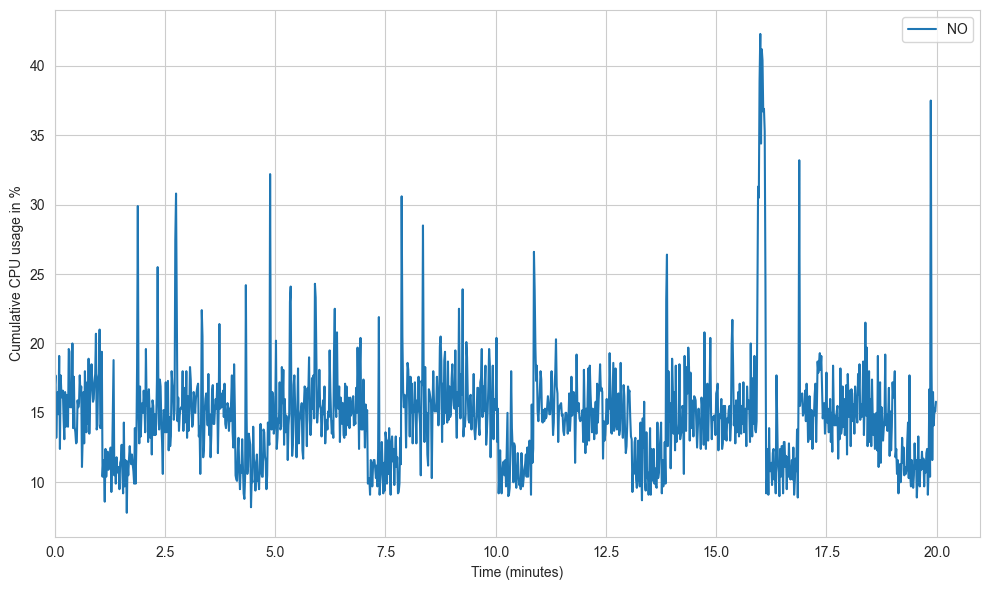

In [175]:
df = data_to_plot['NO']


# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for log_dir, df in data_to_plot.items():
    plt.plot(df['Relative_Time'], df['cumulative_cpu'], label=log_dir)

plt.xlabel('Time (minutes)')
plt.ylabel('Cumulative CPU usage in %')
plt.xlim(left=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()